In [ ]:
!pip install wandb 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from sklearn import manifold
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
import scipy.io
from scipy.io import loadmat
import scipy.io as sio
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torchvision import datasets, transforms
import cv2

## 1.1.a

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: atif20523. Use `wandb login --relogin` to force relogin


True

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
path_data = "/content/gdrive/MyDrive/dataset/train_32x32.mat"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Loading the dataset
matrix = scipy.io.loadmat(path_data)

# Extract images and labels
images = matrix['X']
labels = matrix['y']

In [ ]:
labels[labels == 10] = 0

In [ ]:
images = np.transpose(images, (3, 0, 1, 2))

In [ ]:
print(images.shape)
print(labels.shape)

(73257, 32, 32, 3)
(73257, 1)


The data in the train_32x32.mat file is stored in a struct object, which is a MATLAB data structure that contains multiple fields. In this case, the two main fields are:

X: This is a 4-dimensional array that contains the images. The shape of X is (32, 32, 3, num_samples), where 32 is the height and width of each image, 3 is the number of color channels (RGB), and num_samples is the number of images in the dataset.

y: This is a 2-dimensional array that contains the labels for each image. The shape of y is (num_samples, 1). The labels are integers in the range of 1 to 10, where 0 represents the digit '0' and 10 represents the digit '1'.

The data in the train_32x32.mat file is stored in the MATLAB format, and you can use the scipy.io library in Python to load the data and extract the image data and labels.


In [ ]:
num_samples = 73257

In [ ]:
# Split the data into training, validation, and testing sets
val_split = int(0.2 * num_samples)
test_split = int(0.1 * num_samples) + val_split

In [ ]:
# validation data splitted to 20% of the dataset
val_data = images[:val_split ,:, :, :]  
val_labels = labels[:val_split]

# testing data splitted to 10% of the dataset
test_data = images[val_split:test_split, :, :, :]
test_labels = labels[val_split:test_split]

# rest reserved for training data
train_data = images[test_split:, :, :, :]
train_labels = labels[test_split:]

In [ ]:
print("train_data: ", train_data.shape)
print("train_labels: ", train_labels.shape)
print("val_data: ", val_data.shape)
print("val_labels: ", val_labels.shape)
print("test_data: ", test_data.shape)
print("test_labels: ", test_labels.shape)

train_data:  (51281, 32, 32, 3)
train_labels:  (51281, 1)
val_data:  (14651, 32, 32, 3)
val_labels:  (14651, 1)
test_data:  (7325, 32, 32, 3)
test_labels:  (7325, 1)


In [ ]:
# Initialize a W&B run
wandb.init(project='housenumbers')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1.1.b


In [ ]:
class HouseNumbersDataset(Dataset):
    def __init__(self, mat_file, transform=None):
        self.data = sio.loadmat(mat_file)['X']
        self.target = sio.loadmat(mat_file)['y'].squeeze()
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        img = self.data[:, :, :, index]
        img = torch.tensor(self.data[index], dtype = torch.float32)
        target =  torch.tensor(self.target[index], dtype = torch.float32)
        return img, target

# Load the entire dataset
all_data = HouseNumbersDataset(path_data)


# Define the data loaders for each split
train_loader = torch.utils.data.DataLoader(all_data, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

## 1.1.c

In [ ]:
t = train_data.reshape(-1, 32*32*3)
v = val_data.reshape(-1, 32*32*3)

In [ ]:
# Calculating the number of samples for each class in the training and validation sets
train_counts = []
val_counts = []
test_counts = []

for i in range(10):
  train_counts.append(np.count_nonzero(train_labels == i+1))
  val_counts.append(np.count_nonzero(val_labels == i+1))
  test_counts.append(np.count_nonzero(test_labels == i+1))


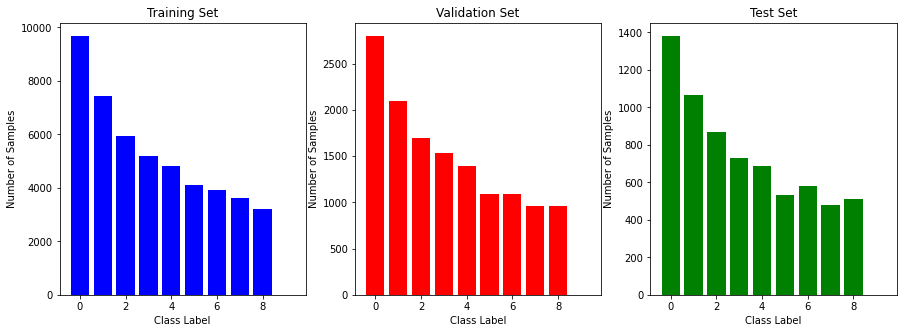

In [ ]:
# Plotting the bar graphdata
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].bar(range(10), train_counts, color='blue')
ax[0].set_xlabel("Class Label")
ax[0].set_ylabel("Number of Samples")
ax[0].set_title("Training Set")

ax[1].bar(range(10), val_counts, color='red')
ax[1].set_xlabel("Class Label")
ax[1].set_ylabel("Number of Samples")
ax[1].set_title("Validation Set")

ax[2].bar(range(10), test_counts, color='green')
ax[2].set_xlabel("Class Label")
ax[2].set_ylabel("Number of Samples")
ax[2].set_title("Test Set")

plt.show()



```
# This is formatted as code
```

# 1.2.a

CNN architecture with 2 Convolution Layers

In [ ]:
class CNN_SVHN(nn.Module):
    def __init__(self):
        super(CNN_SVHN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=64 * 8 * 8, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc(x)
        return x


In [ ]:
def loss_calculator(model, dataloader):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        inputs = inputs.reshape(-1, 3, 32, 32)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def accuracy_calculator(model, dataloader):
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * (correct / total)

Training the model using the Cross-Entropy Loss.

In [ ]:
# Initialize a WandB run
wandb.init(project="CrossEntropyLossTraining")

# Define the CNN_SVHN architecture
model = CNN_SVHN()
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define the data transform and loading
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
valset = datasets.SVHN(root='./data', split='extra', download=True, transform=transform)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

  0%|          | 0/1329278602 [00:00<?, ?it/s]

## Defining the loaders to be used to train the model

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)

In [ ]:
# Train the model

for epoch in range(10):

    # Training loss
    train_loss = loss_calculator(model, trainloader)
    wandb.log({'Training Loss': train_loss})
    print("Training Loss: ", train_loss)

    #Training accuracy
    train_accuracy = accuracy_calculator(model, trainloader)
    wandb.log({'Training Accuracy': train_accuracy})
    print('Training Accuracy: {:.5f} %'.format(train_accuracy))

    # Validation Loss
    validation_loss = loss_calculator(model, valloader) # pass valloader
    wandb.log({'Validation Loss': validation_loss})
    print("Validation Loss: ", validation_loss)

    # Validation accuracy
    validation_accuracy = accuracy_calculator(model, valloader)
    wandb.log({'Validation Accuracy': validation_accuracy})
    print('Validation Accuracy: {:.5f} %'.format(validation_accuracy))

    print("\nEpochs completed: ", epoch+1)
    print()

print('Finished Training')


Training Loss:  1.9854501517318743
Training Accuracy: 66.28991 %
Validation Loss:  0.37249526658538357
Validation Accuracy: 92.95390 %

Epochs completed:  1

Training Loss:  0.5299452937065774
Training Accuracy: 87.01285 %
Validation Loss:  0.25962643152376536
Validation Accuracy: 94.08413 %

Epochs completed:  2

Training Loss:  0.46755901230702496
Training Accuracy: 88.59904 %
Validation Loss:  0.22571339436746643
Validation Accuracy: 94.69641 %

Epochs completed:  3

Training Loss:  0.4300343887904846
Training Accuracy: 89.38531 %
Validation Loss:  0.2046079793341907
Validation Accuracy: 95.05583 %

Epochs completed:  4

Training Loss:  0.401295516597652
Training Accuracy: 89.84261 %
Validation Loss:  0.18952920084740027
Validation Accuracy: 95.33072 %

Epochs completed:  5

Training Loss:  0.3813056267797947
Training Accuracy: 90.21936 %
Validation Loss:  0.1781339600935261
Validation Accuracy: 95.51523 %

Epochs completed:  6

Training Loss:  0.36496661014887444
Training Accuracy:

## Accuracy and F1-score

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

wandb.init(project="accuracy_and_f1Score")

# Define the confusion matrix
def plot_confusion_matrix(conf_matrix):
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    print(conf_matrix)
    wandb.log({'Confusion Matrix': wandb.Image(conf_matrix, caption='Confusion Matrix')})

correct = 0
total = 0
conf_matrix = np.zeros((10,10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        conf_matrix += confusion_matrix(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy(), labels=list(range(10)))

accuracy = 100 * correct / total
f1 = f1_score(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy(), average='weighted')

# Log the Accuracy, F1-Score and Confusion Matrix
wandb.log({'Test Accuracy': accuracy, 'Test F1-Score': f1})

plot_confusion_matrix(conf_matrix)

print('Test Accuracy: {:.5f}%'.format(accuracy))
print('Test F1-Score: {:.2f}'.format(f1))

[[0.90137615 0.00802752 0.01261468 0.01204128 0.00458716 0.00229358
  0.0212156  0.00401376 0.01433486 0.01949541]
 [0.01176701 0.90037262 0.00960973 0.01666994 0.02765248 0.00411845
  0.00411845 0.01196313 0.00941361 0.00431457]
 [0.00168715 0.00457942 0.93323692 0.02410219 0.0098819  0.00385635
  0.0021692  0.00650759 0.00650759 0.00747168]
 [0.00242887 0.00693963 0.01839001 0.90423317 0.0055517  0.01734906
  0.00520472 0.00242887 0.02047189 0.01700208]
 [0.0051526  0.01307967 0.01030519 0.01189061 0.93460166 0.00198177
  0.00673801 0.00317083 0.0051526  0.00792707]
 [0.00209732 0.00503356 0.00713087 0.04530201 0.00964765 0.89177852
  0.0113255  0.00251678 0.01174497 0.01342282]
 [0.01062215 0.0091047  0.00455235 0.02326758 0.02326758 0.03844208
  0.84269095 0.0030349  0.03692463 0.00809307]
 [0.00643883 0.02526003 0.02080238 0.02278356 0.00792472 0.00594354
  0.00396236 0.89153046 0.00495295 0.01040119]
 [0.00722892 0.00481928 0.00722892 0.05       0.00963855 0.01807229
  0.02289157

## 1.3.a

In [ ]:
def loss_calculator_RESNET18(model, dataloader):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        inputs = inputs.reshape(-1, 3, 32, 32)
        outputs = model(inputs)
        torch.set_grad_enabled(True)
        loss = criterion(outputs, labels)
        loss.requires_grad = True
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

## Training another classification model with a fine-tuned Resnet-18 architecture

In [ ]:
# Initialize W&B
wandb.init(project='ResNet18_FineTuning')

# Load the pretrained ResNet-18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze all the layers except the last one
for param in model.parameters():
    param.requires_grad = False
model.fc.requires_grad = True

model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Train the model
for epoch in range(1):  # loop over the dataset multiple times

    # Training loss
    train_loss = loss_calculator_RESNET18(model, trainloader)
    wandb.log({'Training Loss': train_loss})
    print("Training Loss: ", train_loss)

    #Training accuracy
    train_accuracy = accuracy_calculator(model, trainloader)
    wandb.log({'Training Accuracy': train_accuracy})
    print('Training Accuracy: {:.5f} %'.format(train_accuracy))

    # Validation Loss
    validation_loss = loss_calculator_RESNET18(model, valloader)
    wandb.log({'Validation Loss': validation_loss})
    print("Validation Loss: ", validation_loss)

    # Validation accuracy
    validation_accuracy = accuracy_calculator(model, valloader)
    wandb.log({'Validation Accuracy': validation_accuracy})
    print('Validation Accuracy: {:.5f} %'.format(validation_accuracy))

    print("\nEpochs completed: ", epoch+1)
    
print('Finished Training')


Test Accuracy,▁
Test F1-Score,▁
Training Accuracy,▁▇▇▇██████
Training Loss,█▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇██
Validation Loss,█▄▃▃▂▂▂▁▁▁
Test Accuracy,89.95851
Test F1-Score,0.85417
Training Accuracy,91.24452
Training Loss,0.33309
Validation Accuracy,96.07893


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Training Loss:  13.602609575679729
Training Accuracy: 0.08327 %
Validation Loss:  1.8731173447405434
Validation Accuracy: 0.07362 %

Epochs completed:  1
Finished Training


## 1.3.b

In [ ]:
# Calculate the accuracy and F1-Score on the test set

wandb.init(project="accuracy_f1score_1.3.b")
test_acc = accuracy_calculator(model, testloader)
predictions = []
ground_truth = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())
        ground_truth.extend(labels.tolist())
        
# Log the accuracy and F1-Score
wandb.log({'Training Accuracy': test_acc})
print('Training Accuracy: {:.5f} %'.format(train_accuracy))

# Calculate the F1-Score
f1 = f1_score(ground_truth, predictions, average='macro')
wandb.log({'Test F1-Score': f1})
print('Training Accuracy: {:.5f}%'.format(test_acc))
print('Training F1-Score: {:.5f}'.format(f1))

# Log the confusion matrix
cm = confusion_matrix(ground_truth, predictions)
print(cm)
wandb.log({'Confusion Matrix': [cm]})

wandb: WARNING Serializing object of type ndarray that is 7904408 bytes


Training Accuracy: 0.08327 %
Training Accuracy: 0.07299%
Training F1-Score: 0.00001
[[ 2  0  1 ...  0 11  1]
 [ 1  4  6 ...  1  9  8]
 [ 1  9  6 ...  7  7  3]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


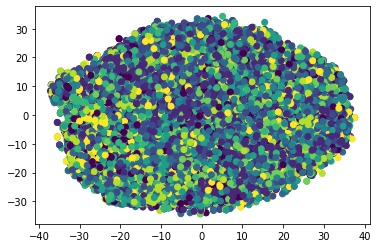

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: ignored

In [ ]:
# Define the ResNet-18 model
model = torchvision.models.resnet18(pretrained=True)
model = model.to(device)

# Remove the last layer (the classification layer)
new_classifier = torch.nn.Sequential(*list(model.children())[:-1])

# Freeze all layers
for param in new_classifier.parameters():
    param.requiresGrad = False

# Extract features from the training set
features_train = []
labels_train = []
for data in trainloader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    features = new_classifier(images)
    features = features.type(torch.FloatTensor).to(device)
    features = features.view(features.size(0), -1)
    features_train.append(features.cpu().detach().numpy())
    labels_train.append(labels.cpu().numpy())
    
# Concatenate all features and labels
features_train = np.concatenate(features_train)
labels_train = np.concatenate(labels_train)

# Extract features from the validation set
features_val = []
labels_val = []
for data in testloader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    features = new_classifier(images)
    features_val.append(features.cpu().detach().numpy())
    labels_val.append(labels.cpu().numpy())

# Concatenate all features and labels
features_val = np.concatenate(features_val)
labels_val = np.concatenate(labels_val)

# Visualize the training set in 2D using t-SNE
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(features_train)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels_train)
plt.show()

# Visualize the validation set in 3D using t-SNE
tsne = TSNE(n_components=3)
features_tsne = tsne.fit_transform(features_val)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c=labels_val)
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


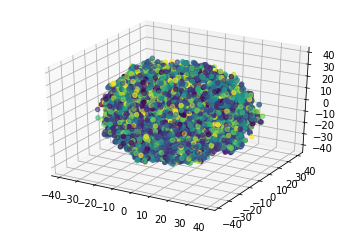

In [ ]:
from sklearn.decomposition import PCA

features_val = np.reshape(features_val, (features_val.shape[0], -1))
pca = PCA(n_components=50)
pca_features = pca.fit_transform(features_val)

tsne = TSNE(n_components=3)
tsne_features = tsne.fit_transform(pca_features)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_features[:, 0], tsne_features[:, 1], tsne_features[:, 2], c=labels_val)
plt.show()

## 1.4.a

# Techniques used for Data Augmentation are Random Cropping, Random Erasing and Random Rotation.


### Random Cropping

In [ ]:
def random_crop(img, sz):
    # height, width = img.shape[:2]
    h = img.shape[0]
    w = img.shape[1]
    ch, cw = sz

    y = np.random.randint(0, h - ch + 1)
    x = np.random.randint(0, w - cw + 1)

    return img[y:y+ch, x:x+cw, :]


In [ ]:
# Loading the dataset
matrix = scipy.io.loadmat(path_data)

# Extract images and labels
images = matrix['X']
labels = matrix['y']

In [ ]:
images = np.transpose(images, (3, 0, 1, 2))

In [ ]:
print(images.shape)

(73257, 32, 32, 3)


In [ ]:
X_image = images

for i in range(0, len(X_image), 150):
    new_image = random_crop(X_image[i], (32, 32))
    images = np.append(images, [new_image], axis=0)

y_labels = labels

for i in range(0, len(y_labels), 150):
    labels = np.append(labels, [y_labels[i]], axis=0)

## Random Erasing


In [ ]:
def random_erasing(img):

    if np.random.uniform() > 0.5:
        return img

    h = img.shape[0]
    w = img.shape[1]
    c = img.shape[2]

    # h, w, c = img.shape
    area = h * w

    while True:
        target_area = np.random.uniform(0.02, 0.4) * area
        aspect_ratio = np.random.uniform(0.3, 3.3)
        er_h = int(round(np.sqrt(target_area * aspect_ratio)))
        er_w = int(round(np.sqrt(target_area / aspect_ratio)))
        if er_h < h and er_w < w:
            break

    x1 = np.random.randint(0, h - er_h)
    y1 = np.random.randint(0, w - er_w)

    if c == 1:
        img[x1:x1+er_h, y1:y1+er_w] = np.random.uniform(0, 1)
    else:
        for i in range(c):
            img[x1:x1+er_h, y1:y1+er_w, i] = np.random.uniform(0, 1)

    return img


In [ ]:
X_image = images

for i in range(2000, len(X_image), 150):
    aug_img = random_erasing(X_image[i])
    images = np.append(images, [aug_img], axis=0)

y_labels = labels

for i in range(2000, len(y_labels), 150):
    labels = np.append(labels, [y_labels[i]], axis=0)

## Random Rotation

In [ ]:
def random_rotation(img, angle_range=(-15, 15)):

    # Generating a random rotation
    angle = np.random.uniform(angle_range[0], angle_range[1])

    # Image center
    h, w = img.shape[:2]
    cx, cy = w // 2, h // 2

    # Rotation matrix
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)

    # Apply the rotation 
    rotated_img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    return rotated_img


In [ ]:
X_image = images

for i in range(2000, len(X_image), 150):
    aug_img = random_rotation(X_image[i], angle_range=(-15, 15))
    images = np.append(images, [aug_img], axis=0)


y_labels = labels

for i in range(2000, len(y_labels), 150):
    labels = np.append(labels, [y_labels[i]], axis=0)


# Training the model again

In [ ]:
# Define the CNN_SVHN architecture
model = CNN_SVHN()
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define the data transform and loading
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
valset = datasets.SVHN(root='./data', split='extra', download=True, transform=transform)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Using downloaded and verified file: ./data/extra_32x32.mat


# Defining the dataloaders


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)

In [ ]:
wandb.init(project="TrainingAgainWithDataAugmentation")

# Train the model
for epoch in range(10):

    # Training loss
    train_loss = loss_calculator(model, trainloader)
    wandb.log({'Training Loss': train_loss})
    print("Training Loss: ", train_loss)

    #Training accuracy
    train_accuracy = accuracy_calculator(model, trainloader)
    wandb.log({'Training Accuracy': train_accuracy})
    print('Training Accuracy: {:.5f} %'.format(train_accuracy))

    # Validation Loss
    validation_loss = loss_calculator(model, valloader) # pass valloader
    wandb.log({'Validation Loss': validation_loss})
    print("Validation Loss: ", validation_loss)

    # Validation accuracy
    validation_accuracy = accuracy_calculator(model, valloader)
    wandb.log({'Validation Accuracy': validation_accuracy})
    print('Validation Accuracy: {:.5f} %'.format(validation_accuracy))

    print("\nEpochs completed: ", epoch+1)
    print()

print('Finished Training')

Training Loss,▁
Training Loss,2.06927


Training Loss:  1.9182365441947005
Training Accuracy: 68.29518 %
Validation Loss:  0.37964457994189366
Validation Accuracy: 92.58111 %

Epochs completed:  1

Training Loss:  0.5387102104170354
Training Accuracy: 86.54463 %
Validation Loss:  0.2640455860024221
Validation Accuracy: 93.95686 %

Epochs completed:  2

Training Loss:  0.47364869610646404
Training Accuracy: 88.25368 %
Validation Loss:  0.2296569794627824
Validation Accuracy: 94.53261 %

Epochs completed:  3

Training Loss:  0.4385226310389401
Training Accuracy: 89.22151 %
Validation Loss:  0.20869732326500257
Validation Accuracy: 94.90163 %

Epochs completed:  4

Training Loss:  0.41065535854434343
Training Accuracy: 89.93816 %
Validation Loss:  0.19330895550557925
Validation Accuracy: 95.19008 %

Epochs completed:  5

Training Loss:  0.38848469275086467
Training Accuracy: 90.07057 %
Validation Loss:  0.18104556860970317
Validation Accuracy: 95.42900 %

Epochs completed:  6

Training Loss:  0.3715506811459512
Training Accurac

# Reporting the accuracy and F1-score

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

wandb.init(project="accuracy-f1score-lastmodel")
# Define the confusion matrix
def plot_confusion_matrix(conf_matrix):
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    print(conf_matrix)
    wandb.log({'Confusion Matrix': wandb.Image(conf_matrix, caption='Confusion Matrix')})

correct = 0
total = 0
conf_matrix = np.zeros((10,10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        conf_matrix += confusion_matrix(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy(), labels=list(range(10)))

accuracy = 100 * correct / total
f1 = f1_score(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy(), average='weighted')

# Log the Accuracy, F1-Score and Confusion Matrix
wandb.log({'Test Accuracy': accuracy, 'Test F1-Score': f1})

plot_confusion_matrix(conf_matrix)

print('Test Accuracy: {:.5f}%'.format(accuracy))
print('Test F1-Score: {:.2f}'.format(f1))

Training Accuracy,▁▇▇▇██████
Training Loss,█▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇██
Validation Loss,█▄▃▃▂▂▂▁▁▁
Training Accuracy,91.13668
Training Loss,0.33805
Validation Accuracy,95.97839
Validation Loss,0.15231


[[0.89220183 0.00630734 0.01834862 0.01261468 0.00401376 0.00401376
  0.02178899 0.00401376 0.02236239 0.01433486]
 [0.01196313 0.90370661 0.0127476  0.015101   0.02373014 0.00451069
  0.00392234 0.01313983 0.00804079 0.00313787]
 [0.00168715 0.00578453 0.9351651  0.02265606 0.0077127  0.00482044
  0.00313329 0.00530248 0.00747168 0.00626657]
 [0.00208189 0.00693963 0.01873699 0.89382373 0.00277585 0.02290076
  0.00624566 0.00312283 0.03018737 0.01318529]
 [0.00396354 0.01545779 0.01268331 0.01585414 0.92072929 0.00317083
  0.00871978 0.00396354 0.00832342 0.00713436]
 [0.00251678 0.00671141 0.00838926 0.0432047  0.00629195 0.89387584
  0.01300336 0.00251678 0.01216443 0.0113255 ]
 [0.01264542 0.01365706 0.00708144 0.02377339 0.01416287 0.03793627
  0.84167931 0.0030349  0.03743045 0.00859889]
 [0.00643883 0.02625062 0.0277365  0.01733531 0.00495295 0.00643883
  0.00495295 0.89202576 0.00495295 0.0089153 ]
 [0.0060241  0.00481928 0.00542169 0.03975904 0.00903614 0.01746988
  0.01686747